In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
# import folium
from ast import literal_eval
import json


import ast

import sys
import os


import matplotlib.gridspec as gridspec
# import folium
# from folium import FeatureGroup
from matplotlib import style
style.use('seaborn-darkgrid')


# import keplergl



from datetime import datetime

from sklearn import preprocessing


%matplotlib inline
# sns.set_style("seaborn-darkgrid")

# Read data

In [2]:
def Get_ModelData_WithLabels():
    #kmean results
    kmean_results_labels = pd.read_csv(
        'results/kmeans_results_all_TimeZoneCorrected_08202021_only10PCs.csv')
    #kmeans_results_all_TimeZoneCorrected_08202021.csv')
    # kmean_results

    #model data
    kmean_results = pd.read_csv(
        '_Data/model data/model_data_TimeZoneCorrected_08192021.csv'
    )  #model_data_TimeZoneCorrected_08192021.csv')
    # PCA_model_data

    #add labels to the model data
    kmean_results['KMeans_15_labels'] = literal_eval(
        kmean_results_labels[kmean_results_labels['Cluster_no'] ==
                             15]['Kmeans_label_list'].values.tolist()[0])

    kmean_results['StartTime_decimal'] = kmean_results.apply(
        lambda x: x['StartTime_decimal'] + 24
        if x['StartTime_decimal'] <= 6 else x['StartTime_decimal'],
        axis=1)

    #add flag for trips starting or ending at Vanderbilt and Parks
    kmean_results['VANDERBILT_trip'] = kmean_results.apply(
        lambda x: 1
        if (x['VANDERBILT_start'] == 1) | (x['VANDERBILT_end'] == 1) else 0,
        axis=1)

    kmean_results['PARK_trip'] = kmean_results.apply(
        lambda x: 1 if (x['PARK_start'] == 1) | (x['PARK_end'] == 1) else 0,
        axis=1)

    print(kmean_results.shape)
    print(kmean_results.columns)

    return kmean_results


kmean_results = Get_ModelData_WithLabels()
kmean_results.head()

(1050497, 50)
Index(['Unnamed: 0', 'trip_id', 'GRID_ID_start', 'GRID_ID_end',
       'enthropy_start', 'MEAN_CBD_start', 'MEAN_URBAN_start', 'MEAN_SU_start',
       'MEAN_RURAL_start', 'MEAN_POP_D_start', 'MEAN_EMP_D_start',
       'MEAN_PAKING_start', 'intersection_density_start', 'enthropy_end',
       'MEAN_CBD_end', 'MEAN_URBAN_end', 'MEAN_SU_end', 'MEAN_RURAL_end',
       'MEAN_POP_D_end', 'MEAN_EMP_D_end', 'MEAN_PAKING_end',
       'intersection_density_end', 'PARK_start', 'VANDERBILT_start',
       'NISSAN_start', 'PARK_end', 'VANDERBILT_end', 'NISSAN_end',
       'tripDistance_miles', 'tripDistance', 'tripDuration',
       'euclidean_distance', 'StartTime_decimal', 'route_directness_rawDist',
       'route_directness_trace', 'average_trip_speed_mph',
       'trip_start_week_no', 'trip_start_hour_no', 'StartTime_AMPeak',
       'StartTime_Day', 'StartTime_PMPeak', 'StartTime_Night', 'weekend_trip',
       'high_trip_count_day', 'DATE_str', 'PRCP', 'TAVG', 'KMeans_15_labels',
   

,Unnamed: 0,trip_id,GRID_ID_start,GRID_ID_end,enthropy_start,MEAN_CBD_start,MEAN_URBAN_start,MEAN_SU_start,MEAN_RURAL_start,MEAN_POP_D_start,...,StartTime_PMPeak,StartTime_Night,weekend_trip,high_trip_count_day,DATE_str,PRCP,TAVG,KMeans_15_labels,VANDERBILT_trip,PARK_trip
0,0,9,DN-110,DR-111,0.928214,0.90,0.00,0.0,0.0,15831.781111,...,0,0,0,0,2018-09-01,0.02,79,13,0,0
1,1,10,DK-106,DL-107,0.598365,0.35,0.55,0.0,0.0,3230.462036,...,0,0,0,0,2018-09-01,0.02,79,8,0,1
2,2,11,DO-110,DM-106,0.830590,0.90,0.00,0.0,0.0,6957.366348,...,0,0,0,0,2018-09-01,0.02,79,13,0,0
3,3,12,DM-110,DN-110,0.865962,0.90,0.00,0.0,0.0,6847.949890,...,0,0,0,0,2018-09-01,0.02,79,13,0,0
4,4,13,DO-110,DM-106,0.830590,0.90,0.00,0.0,0.0,6957.366348,...,0,0,0,0,2018-09-01,0.02,79,13,0,0


In [3]:
def Link_OriginDesitination_Coords(kmean_results):
    trip_data = pd.read_csv(
        '_Data/trip data/start_end_points_cleaned_TimeZoneCorrected_08192021.csv')
    trip_data['startDateTime'] = pd.to_datetime(
        trip_data['startDateTime'], utc=True).dt.tz_convert('US/Central')

    kmeans_results_linkCoords=pd.merge(kmean_results,
             trip_data[['trip_id','startLatitude','startLongitude','endLatitude',
                        'endLongitude','weekend_trip','startDateTime']],
             on='trip_id',
             how='left')
    kmeans_results_linkCoords.to_csv('_Data/model data/ClusteringResults_Interpretation_TimeZoneCorrected_08222021_v1.csv')       

    return kmeans_results_linkCoords

kmeans_results_linkCoords=Link_OriginDesitination_Coords(kmean_results)
kmeans_results_linkCoords.head()

In [4]:
kmeans_results_linkCoords[['trip_id','startDateTime','DATE_str']].to_csv('_Data/model data/tripID_NewClusters_08252021.csv')

# Interpreting individual clusters

## functions for plotting

In [33]:
rename_variables = {
    'tripDistance_miles': 'Trip distance (miles)',
    'tripDuration': 'Trip duration (minutes)',
    'route_directness_trace': 'Route directness ratio',
    'average_trip_speed_mph': 'Average trip speed (mph)',
    'high_trip_count_day': 'Trips on special event',
    'weekend_trip': 'Weekend trips',
    'StartTime_AMPeak': 'Trip during 7 am and 10 am',
    'StartTime_Day': 'Trip during 10 am and 4 pm',
    'StartTime_PMPeak': 'Trip during 4 pm and 8 pm',
    'StartTime_Night': 'Trip during 8 pm and 7 am',
    'PRCP': 'Average daily precipitation',
    'TAVG': 'Average daily temperature',
    'MEAN_CBD_start': 'Proportion of CBD land use at origin',
    'MEAN_URBAN_start': 'Proportion of urban land use at origin',
    'MEAN_SU_start': 'Proportion of sub-urban land use at origin',
    'MEAN_RURAL_start': 'Proportion of rural land use at origin',
    'MEAN_POP_D_start': 'Average population density at origin',
    'MEAN_EMP_D_start': 'Average employment density at origin',
    'MEAN_PAKING_start': 'Average parking density at origin',
    'intersection_density_start':
    'Intersection density (per sq. miles) at origin',
    'enthropy_start': 'Entropy at origin',
    'MEAN_CBD_end': 'Proportion of CBD land use at destination',
    'MEAN_URBAN_end': 'Proportion of urban land use at destination',
    'MEAN_SU_end': 'Proportion of sub-urban land use at destination',
    'MEAN_RURAL_end': 'Proportion of rural land use at destination',
    'MEAN_POP_D_end': 'Average population density at destination',
    'MEAN_EMP_D_end': 'Average employment density at destination',
    'MEAN_PAKING_end': 'Average parking density at destination',
    'intersection_density_end':
    'Intersection density (per sq. miles) at destination',
    'enthropy_end': 'Entropy at destination'
}

rename_variables_spyder = {
    'tripDistance_miles': 'Trip distance',
    'tripDuration': 'Trip duration',
    'route_directness_trace': 'Route directness ratio',
    'average_trip_speed_mph': 'Average trip speed',
    'high_trip_count_day': 'Special event trips',
    'weekend_trip': 'Weekend trips',
    'StartTime_AMPeak': 'Trip during 7 am and 10 am',
    'StartTime_Day': 'Trip during 10 am and 4 pm',
    'StartTime_PMPeak': 'Trip during 4 pm and 8 pm',
    'StartTime_Night': 'Trip during 8 pm and 7 am',
    'PRCP': 'Average daily precipitation',
    'TAVG': 'Temperature',
    'MEAN_CBD_start': 'CBD land use at origin',
    'MEAN_URBAN_start': 'Urban land use at origin',
    'MEAN_POP_D_start': 'Population density at origin',
    'MEAN_EMP_D_start': 'Employment density at origin',
    'enthropy_start': 'Entropy at origin',
    'MEAN_CBD_end': 'CBD land use at destination',
    'MEAN_URBAN_end': 'Urban land use at destination',
    'MEAN_POP_D_end': 'Population density at destination',
    'MEAN_EMP_D_end': 'Employment density at destination',
    'enthropy_end': 'Entropy at destination',
    'VANDERBILT_trip':'Vanderbilt trips', 
    'PARK_trip':'Park trips'
}

In [30]:
labels = [
    'MEAN_CBD_start', 'MEAN_URBAN_start', 'MEAN_POP_D_start',
    'MEAN_EMP_D_start', 'enthropy_start', 'MEAN_CBD_end', 'MEAN_URBAN_end',
    'MEAN_POP_D_end', 'MEAN_EMP_D_end', 'enthropy_end'
]

[rename_variables_spyder[label] for label in labels]

['CBD land use at origin',
 'Urban land use at origin',
 'Population density at origin',
 'Employment density at origin',
 'Entropy at origin',
 'CBD land use at destination',
 'Urban land use at destination',
 'Population density at destination',
 'Employment density at destination',
 'Entropy at destination']

In [5]:
def get_scaled_data(spyder_plot_vars):

    #combine variables 
    var_spyder_mean = spyder_plot_vars['trip']['mean'] + spyder_plot_vars[
        'spatial']['mean']
    var_spyder_median = spyder_plot_vars['trip']['median'] + spyder_plot_vars[
        'spatial']['median']

    var_spyder_all = var_spyder_median + var_spyder_mean

    # slice variable of interest
    data_for_sypder_plot = kmean_results[var_spyder_median + var_spyder_mean]

    # #standarize the data
    scaler = preprocessing.StandardScaler()#.MinMaxScaler()
    data_for_sypder_plot_scaled = pd.DataFrame(
        scaler.fit_transform(data_for_sypder_plot), columns=var_spyder_all)
    #add cluster label column to the scaled data
    data_for_sypder_plot_scaled[cluster_label_var] = kmean_results[
        cluster_label_var]


    data_for_sypder_plot_scaled
    
    return data_for_sypder_plot_scaled

In [41]:
np.arange(0, 0.6, 0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5])

In [42]:
# def grouped_temporal_plot(subplot_data, group_clusters, ax):

#     for individual_cluster in group_clusters:
#         sns.kdeplot(subplot_data[subplot_data[cluster_label_var] ==
#                                  individual_cluster]['StartTime_decimal'],
#                     clip=(0, 30),
#                     label=str('C' + str(individual_cluster)),
#                     color=custom_palette[individual_cluster])
# #                     ax=ax)
#         plt.xlim(6, 30)
#         plt.xticks(np.arange(6, 31, 6),
#                    ['6 am', '12 pm', '6 pm', '12 am', '6 am'])

#         #     plt.xticks(np.arange(6, 25, 6))
#         plt.yticks(np.arange(0, 0.2, 0.05), ['', '0.05', '0.1', '0.15'])

#         plt.legend()

#     plt.tight_layout(h_pad=3.0)
#     plt.xlabel('Hour of the day')


#     return plt
def grouped_temporal_plot(subplot_data, individual_cluster, ax, plot_color):

    fig = plt.figure()
    sns.kdeplot(subplot_data[subplot_data[cluster_label_var] ==
                             individual_cluster]['StartTime_decimal'],
                clip=(0, 30),
                label=str('C' + str(individual_cluster)),
                color=plot_color,
                ax=ax)
    ax.set_xlim(6, 30)
    ax.set_xticks(np.arange(6, 31, 6))
    ax.set_xticklabels(('6 am', '12 pm', '6 pm', '12 am', '6 am'))
#     ax.set_xticks(np.arange(6, 31, 6), ['6 am', '12 pm', '6 pm', '12 am', '6 am'])

    #     plt.xticks(np.arange(6, 25, 6))
#     plt.yticks(np.arange(0, 0.2, 0.05), ['', '0.05', '0.1', '0.15'])
    ax.set_ylim(0, 0.6)
    ax.set_yticks(np.arange(0, 0.6, 0.1))
    ax.set_yticklabels(('' , '0.1', '0.2', '0.3', '0.4', '0.5'))

#     plt.legend()

#     plt.tight_layout(h_pad=3.0)
    ax.set_xlabel('Hour of the day')
    ax.grid(True)

    return None
#     return plt

In [35]:
def plot_sypder_plot(individual_cluster_data_scaled, individual_cluster,
                     spyder_plot_vars,spyder_plot_type, ax, plot_color):

    #     individual_cluster = 1
    #
    #     ax
    #     plot_color

    selected_vars_spyder_plot = spyder_plot_vars[spyder_plot_type][
        'median'] + spyder_plot_vars[spyder_plot_type]['mean']

    # #get dataframe of one cluster
    individual_cluster_data_scaled = data_for_sypder_plot_scaled[
        data_for_sypder_plot_scaled[cluster_label_var] ==
        individual_cluster][selected_vars_spyder_plot]
    individual_cluster_data_scaled

    #concate mean and median columns and sum them to get one column
    stats = pd.concat([
        individual_cluster_data_scaled.
        loc[:, spyder_plot_vars[spyder_plot_type]['median']].median(axis=0),
        individual_cluster_data_scaled.
        loc[:, spyder_plot_vars[spyder_plot_type]['mean']].mean(axis=0)
    ],
                      axis=1)

    stats = stats.sum(axis=1)
    angles = np.linspace(0,
                         2 * np.pi,
                         len(selected_vars_spyder_plot),
                         endpoint=False)

    # close the plot
    stats = np.concatenate((stats, [stats[0]]))
    angles = np.concatenate((angles, [angles[0]]))
    labels = [*selected_vars_spyder_plot, selected_vars_spyder_plot[0]]
    labels=[rename_variables_spyder[label] for label in labels]

    fig = plt.figure()
    #ax = fig.add_subplot(111, polar=True)
    ax.plot(angles,
            stats,
            'o-',
            markersize=2,
            linewidth=1.5,
            color=plot_color,
            label=str('C' + str(individual_cluster)))
    ax.fill(angles, stats, alpha=0.05)
#     ax.set_thetagrids(angles[:19] * 180 / np.pi, labels)
    ax.set_thetagrids(angles * 180/np.pi, labels)
    ax.set_yticklabels([])
    #     ax.set_title(str('C' + str(cluster_number)))
    ax.grid(True)

    return None


# individual_cluster = 1
# selected_vars_spyder_plot = spyder_plot_vars['trip'][
#     'median'] + spyder_plot_vars['trip']['mean']
# ax
# plot_color

# plot_sypder_plot(individual_cluster_data_scaled,
#                  individual_cluster=10,
#                  selected_vars_spyder_plot=spyder_plot_vars['trip']['median'] +
#                  spyder_plot_vars['trip']['mean'],
#                  ax=plt.figure(figsize=(4, 9)),
#                  plot_color=sns.color_palette("deep", 16)[0])

## Create plots

In [39]:
cluster_group_dict = {
    'Group1': {
        'Label': 'Morning commute',
        'clusters': [8, 13]
    },
    'Group2': {
        'Label': 'Daytime short errand',
        'clusters': [2, 10, 12]
    },
    'Group3': {
        'Label': 'Evening Social',
        'clusters': [3, 14]
    },
    'Group4': {
        'Label': 'Nighttime',
        'clusters': [6, 7]
    },
    'Group5': {
        'Label': 'utilitarian',
        'clusters': [0, 1, 5]
    },
    'Group6': {
        'Label': 'Recreational',
        'clusters': [4, 11]
    }
}

spyder_plot_vars_dict = {
    'trip': {
        'mean': ['high_trip_count_day', 'weekend_trip'],
        'median': [
            'tripDistance_miles',
            'tripDuration',
            'route_directness_trace',
            'average_trip_speed_mph',
            'TAVG',
        ]
    },
    'spatial': {
        'mean': ['VANDERBILT_trip', 'PARK_trip'],
        'median': [
            'MEAN_CBD_start', 'MEAN_URBAN_start', 'MEAN_POP_D_start',
            'MEAN_EMP_D_start', 'enthropy_start', 'MEAN_CBD_end',
            'MEAN_URBAN_end', 'MEAN_POP_D_end', 'MEAN_EMP_D_end',
            'enthropy_end'
        ]
    }
}

cluster_label_var = 'KMeans_15_labels'
number_of_plot = len(cluster_group_dict)
total_clusters = kmean_results[cluster_label_var].max() + 1

# get scaled data
data_for_sypder_plot_scaled = get_scaled_data(
    spyder_plot_vars=spyder_plot_vars_dict)

style.use('seaborn-darkgrid')
# defind colour pallet
custom_palette = sns.color_palette("deep", total_clusters)

## Trip information spyder plot

Group1


<ipython-input-43-28407dfcf039>:55: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([h1, h2, h3],     # The line objects


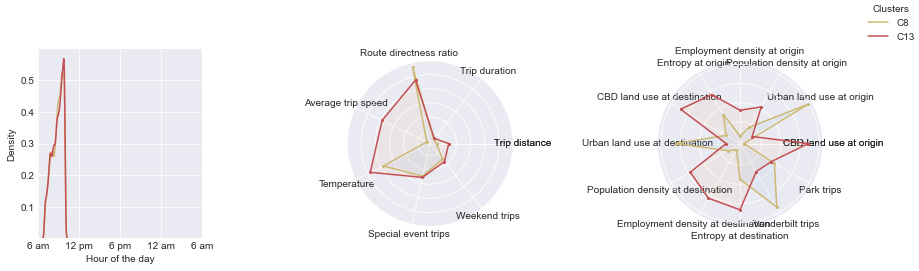

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

Group2


<ipython-input-43-28407dfcf039>:55: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([h1, h2, h3],     # The line objects


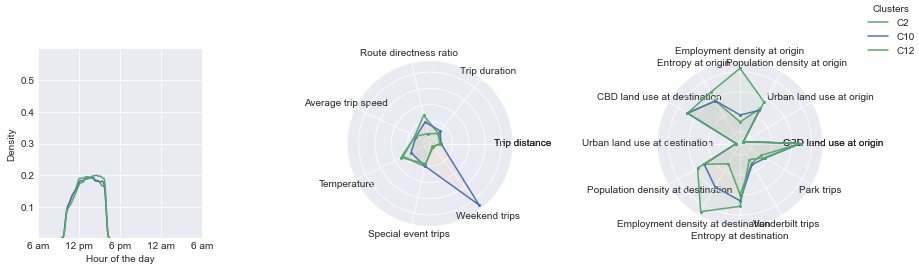

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

Group3


<ipython-input-43-28407dfcf039>:55: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([h1, h2, h3],     # The line objects


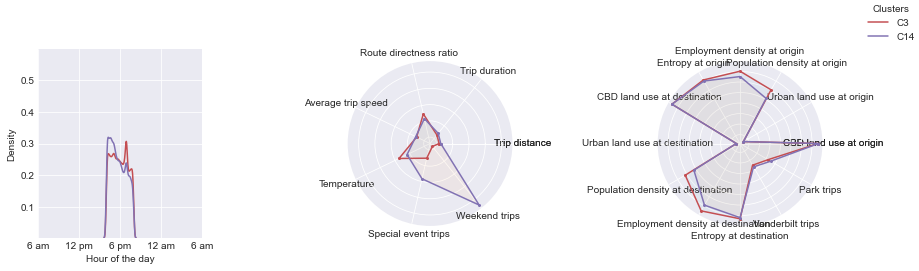

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

Group4


<ipython-input-43-28407dfcf039>:55: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([h1, h2, h3],     # The line objects


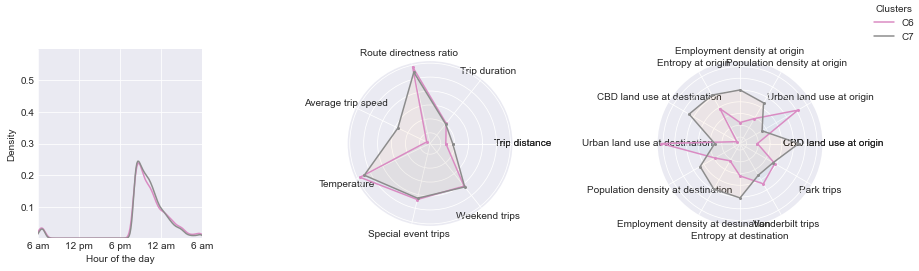

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

Group5


<ipython-input-43-28407dfcf039>:55: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([h1, h2, h3],     # The line objects


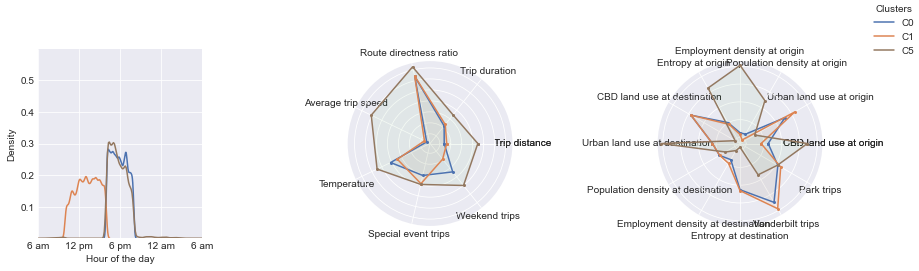

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

Group6


<ipython-input-43-28407dfcf039>:55: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([h1, h2, h3],     # The line objects


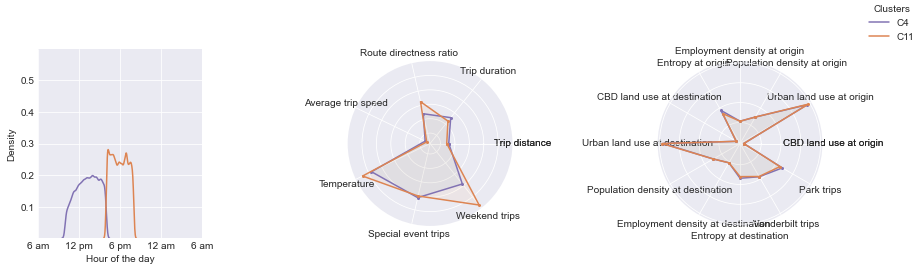

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [43]:
style.use('seaborn-darkgrid')


# fig_outer = plt.figure(figsize=(13, 14))
#     #fig.suptitle('K mean cluster 10')

# gspec = gridspec.GridSpec(len(cluster_group_dict.keys()), 1)
# ax = [plt.subplot(gspec[row, 0], polar=False) for row in np.arange(0,len(cluster_group_dict.keys()))]


for groups in cluster_group_dict.keys():
    print(groups)
    fig = plt.figure(figsize=(13, 4))
    #fig.suptitle('K mean cluster 10')

    gspec = gridspec.GridSpec(1, 3)
    ax1 = plt.subplot(gspec[0, 0], polar=False)
    ax2 = plt.subplot(gspec[0, 1], polar=True)
    ax3 = plt.subplot(gspec[0, 2], polar=True)

    # get list of clusters in group
    group_clusters = cluster_group_dict[groups]['clusters']

#     group_clusters = cluster_group_dict['Group1']['clusters']
    for individual_cluster in group_clusters:
        #     print(individual_cluster)

        # get data for group clusters only
        subplot_data = kmean_results[kmean_results[cluster_label_var].isin(
            group_clusters)][[cluster_label_var, 'StartTime_decimal']]
        h1 = grouped_temporal_plot(subplot_data,
                                   individual_cluster,
                                   ax=ax1,
                                   plot_color=custom_palette[individual_cluster])

        h2 = plot_sypder_plot(
            data_for_sypder_plot_scaled,
            individual_cluster,
            spyder_plot_vars=spyder_plot_vars_dict,
            spyder_plot_type='trip',
            ax=ax2,
            plot_color=custom_palette[individual_cluster])

        h3 = plot_sypder_plot(
            data_for_sypder_plot_scaled,
            individual_cluster,
            spyder_plot_vars=spyder_plot_vars_dict,
            spyder_plot_type='spatial',
            ax=ax3,
            plot_color=custom_palette[individual_cluster])

    # Create the legend
    fig.legend([h1, h2, h3],     # The line objects
               # The labels for each line
               labels=[str('C'+str(cluster_no))
                       for cluster_no in group_clusters],
               loc="upper right",   # Position of legend
               borderaxespad=0.1,    # Small spacing around legend box
               title="Clusters"  # Title for the legend
               )
    fig.tight_layout(pad=3)
    plt.show()

    fig.suptitle(cluster_group_dict[groups]['Label'], fontsize=15)
    fig.savefig(str('results/individual clusters/StandardProcessing_plot_K15_' +
                str(groups)+'_V3.png'), dpi=900)

In [10]:
# fig_outer = plt.figure(figsize=(13, 14), constrained_layout=False)
# outer_grid = fig_outer.add_gridspec(4, 1, wspace=0, hspace=0)
# outer_grid[0].plot('Group1')
#     #fig.suptitle('K mean cluster 10')

# # for row in range(4):

# #     inner_grid = outer_grid[row, 0].subgridspec(1, 3, wspace=0, hspace=0)
# #     axs = inner_grid.subplots()
    
# #     print(len(axs))

# # gspec = gridspec.GridSpec(4, 1)

# # ax1 = plt.subplot(gspec[0, 0], polar=False)
# # ax2 = plt.subplot(gspec[1, 0], polar=False)
# # ax3 = plt.subplot(gspec[2, 0], polar=False)
# # ax4 = plt.subplot(gspec[3, 0], polar=False)

# # inner_grid = ax1.subgridspec(1, 3, wspace=0, hspace=0)
# fig_outer.tight_layout(pad=3)
# plt.show()

## Descriptive stat

In [16]:
var_spyder_median = [
    'tripDistance_miles',
    'tripDuration',
    'route_directness_trace',
    'average_trip_speed_mph',

    'TAVG',
    'MEAN_CBD_start',
    'MEAN_URBAN_start',
    'MEAN_POP_D_start',
    'MEAN_EMP_D_start',
    'MEAN_PAKING_start',
    #     'intersection_density_start',
    'enthropy_start',
    'MEAN_CBD_end',
    'MEAN_URBAN_end',
    'MEAN_POP_D_end',
    'MEAN_EMP_D_end',
    'MEAN_PAKING_end',
    #     'intersection_density_end',
    'enthropy_end'
]

var_spyder_mean = ['high_trip_count_day', 'weekend_trip','StartTime_AMPeak',
       'StartTime_Day', 'StartTime_PMPeak', 'StartTime_Night']



var_spyder_all = var_spyder_median + var_spyder_mean




cluster_number = 15
selected_cluster_to_group = ['KMeans_15_labels']  # ['reclassified_cluster']


# descriptive stats
summary_median = kmean_results[var_spyder_median +
                               selected_cluster_to_group].groupby(selected_cluster_to_group).agg(
                                   [np.mean])
summary_mean = kmean_results[var_spyder_mean +
                             selected_cluster_to_group].groupby(selected_cluster_to_group).agg(
                                 [np.mean])

summary = pd.concat([summary_median, summary_mean], axis=1)


total_special_trips = kmean_results.groupby(selected_cluster_to_group[0])[
    'high_trip_count_day'].sum().sum()
special_trips_by_cluster = kmean_results.groupby(selected_cluster_to_group[0])[
    'high_trip_count_day'].sum()
summary['proportion_of_special_day_trip'] = special_trips_by_cluster / \
    total_special_trips*100

vanderbilt_trips = kmean_results.groupby(selected_cluster_to_group[0])[
    'VANDERBILT_trip'].sum().sum()
vanderbilt_by_cluster = kmean_results.groupby(selected_cluster_to_group[0])[
    'VANDERBILT_trip'].sum()
summary['proportion_of_vanderbilt_trip'] = vanderbilt_by_cluster / \
    vanderbilt_trips*100

park_trips = kmean_results.groupby(selected_cluster_to_group[0])[
    'PARK_trip'].sum().sum()
park_by_cluster = kmean_results.groupby(
    selected_cluster_to_group[0])['PARK_trip'].sum()
summary['proportion_of_park_trip'] = park_by_cluster/park_trips*100

# add proportion column
summary['proportion_of_trips'] = kmean_results.groupby(
    selected_cluster_to_group[0]).size() / len(kmean_results) * 100
# summary['proportion_of_trips'] = kmean_results.groupby(
#     selected_cluster_to_group[0]).size() / len(kmean_results) * 100

total_VMT = kmean_results.groupby(selected_cluster_to_group[0])[
    'tripDistance_miles'].sum().sum()
total_VMT_by_cluster = kmean_results.groupby(selected_cluster_to_group[0])[
    'tripDistance_miles'].sum()
summary['proportion_by_VMT'] = total_VMT_by_cluster/total_VMT*100

total_duration = kmean_results.groupby(selected_cluster_to_group[0])[
    'tripDuration'].sum().sum()
total_duration_by_cluster = kmean_results.groupby(
    selected_cluster_to_group[0])['tripDuration'].sum()
summary['proportion_by_duration'] = total_duration_by_cluster/total_duration*100


summary = summary.transpose().rename(index=rename_variables)

summary.to_csv(
    str('results/AllKmeans_results_TimeZoneCorrected_V1_08262021.csv'))

summary

,KMeans_15_labels,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Trip distance (miles),mean,0.661490,0.737457,0.669854,0.598888,0.740588,1.122049,0.707662,0.643385,0.664803,1.160735,0.769943,0.710735,0.715161,0.689677,0.679444
Trip duration (minutes),mean,15.266241,16.177010,16.126771,15.129465,17.388640,19.198876,15.243230,14.967140,12.790689,20.917693,18.712983,16.481138,18.133783,13.260777,16.420234
Route directness ratio,mean,0.614332,0.628774,0.563211,0.562253,0.441156,0.703584,0.565714,0.573774,0.627480,0.666691,0.513313,0.464150,0.442772,0.587611,0.535900
Average trip speed (mph),mean,2.813334,2.962997,2.847878,2.749747,2.780931,4.156707,3.001237,2.956972,3.425587,3.844428,2.731706,2.813486,2.635265,3.761258,2.733468
Average daily temperature,mean,62.983454,62.070690,64.483214,66.192917,64.329658,66.040465,65.640350,65.275771,64.178137,64.753544,63.948592,65.584369,65.104168,66.486259,64.809062
Proportion of CBD land use at origin,mean,0.515579,0.456302,0.873019,0.885752,0.149091,0.879482,0.344096,0.855173,0.372993,0.870060,0.829742,0.142843,0.888780,0.832959,0.856735
Proportion of urban land use at origin,mean,0.365573,0.427113,0.025649,0.009270,0.746192,0.010802,0.544005,0.035623,0.523076,0.022858,0.062106,0.751332,0.002502,0.059593,0.034766
Average population density at origin,mean,4090.480595,3583.890269,10375.227038,10539.276251,5612.295908,9838.899493,5737.631761,9726.616114,5379.146118,9781.883108,9765.281728,5753.138852,10533.657919,8908.915483,9840.151681
Average employment density at origin,mean,19686.830982,17294.802664,67066.810875,117084.052921,14159.461614,133488.262058,27197.293280,109464.707074,23485.696657,112309.324224,91868.076604,13273.397526,158138.788402,84635.287260,108144.974809
Average parking density at origin,mean,1342.578874,997.926352,8811.720674,21222.467871,358.592134,26373.411810,2858.063840,19683.033988,1685.231556,21141.849250,15552.654396,323.362773,32432.103806,14195.000771,19328.144481


# Groupping clusters

In [64]:
def reclassify_cluster(cluster_group_dict,cluster_value_for_reclassify):
    try:
        for keys in cluster_group_dict.keys():
            if cluster_value_for_reclassify in cluster_group_dict[keys]['clusters']:
                return(cluster_group_dict[keys]['Label'])
    except:
        return None

In [126]:
kmean_results['reclassified_cluster'] = kmean_results.apply(
    lambda x: reclassify_cluster(cluster_group_dict, x['KMeans_15_labels']),
    axis=1)

reclassifed_clusters_list = [
    'Morning commute', 'Daytime short errand', 'Recreational', 'utilitarian',
    'Evening Social', 'Nighttime',None
]

kmean_results['reclassified_cluster_ID'] = kmean_results.apply(
    lambda x: str(reclassifed_clusters_list.index(x['reclassified_cluster'])), axis=1)

Percentage.head()

,Unnamed: 0,trip_id,GRID_ID_start,GRID_ID_end,enthropy_start,MEAN_CBD_start,MEAN_URBAN_start,MEAN_SU_start,MEAN_RURAL_start,MEAN_POP_D_start,...,weekend_trip,high_trip_count_day,DATE_str,PRCP,TAVG,KMeans_15_labels,VANDERBILT_trip,PARK_trip,reclassified_cluster,reclassified_cluster_ID
0,0,9,DN-110,DR-111,0.928214,0.90,0.00,0.0,0.0,15831.781111,...,0,0,2018-09-01,0.02,79,13,0,0,Morning commute,0
1,1,10,DK-106,DL-107,0.598365,0.35,0.55,0.0,0.0,3230.462036,...,0,0,2018-09-01,0.02,79,8,0,1,Morning commute,0
2,2,11,DO-110,DM-106,0.830590,0.90,0.00,0.0,0.0,6957.366348,...,0,0,2018-09-01,0.02,79,13,0,0,Morning commute,0
3,3,12,DM-110,DN-110,0.865962,0.90,0.00,0.0,0.0,6847.949890,...,0,0,2018-09-01,0.02,79,13,0,0,Morning commute,0
4,4,13,DO-110,DM-106,0.830590,0.90,0.00,0.0,0.0,6957.366348,...,0,0,2018-09-01,0.02,79,13,0,0,Morning commute,0


In [128]:
kmean_results['reclassified_cluster_ID'].unique()

array(['0', '1', '6', '2', '3', '4', '5'], dtype=object)

## Descriptive stat

In [130]:
selected_cluster_to_group=['reclassified_cluster']

# descriptive stats
summary_median = kmean_results[var_spyder_median +
                               selected_cluster_to_group].groupby(selected_cluster_to_group).agg(
                                   [np.mean])
summary_mean = kmean_results[var_spyder_mean +
                             selected_cluster_to_group].groupby(selected_cluster_to_group).agg(
                                 [np.mean])

summary = pd.concat([summary_median, summary_mean], axis=1)


total_special_trips = kmean_results.groupby(selected_cluster_to_group[0])[
    'high_trip_count_day'].sum().sum()
special_trips_by_cluster = kmean_results.groupby(selected_cluster_to_group[0])[
    'high_trip_count_day'].sum()
summary['Percentage_of_special_day_trip_inCluster'] = special_trips_by_cluster / \
    total_special_trips*100

vanderbilt_trips = kmean_results.groupby(selected_cluster_to_group[0])[
    'VANDERBILT_trip'].sum().sum()
vanderbilt_by_cluster = kmean_results.groupby(selected_cluster_to_group[0])[
    'VANDERBILT_trip'].sum()
summary['Percentage_of_vanderbilt_trip_inCluster'] = vanderbilt_by_cluster / \
    vanderbilt_trips*100

park_trips = kmean_results.groupby(selected_cluster_to_group[0])[
    'PARK_trip'].sum().sum()
park_by_cluster = kmean_results.groupby(
    selected_cluster_to_group[0])['PARK_trip'].sum()
summary['Percentage_of_park_trip_inCluster'] = park_by_cluster/park_trips*100

# add proportion column
summary['Percentage_of_trips'] = kmean_results.groupby(
    selected_cluster_to_group[0]).size() / len(kmean_results) * 100
# summary['proportion_of_trips'] = kmean_results.groupby(
#     selected_cluster_to_group[0]).size() / len(kmean_results) * 100

total_VMT = kmean_results.groupby(selected_cluster_to_group[0])[
    'tripDistance_miles'].sum().sum()
total_VMT_by_cluster = kmean_results.groupby(selected_cluster_to_group[0])[
    'tripDistance_miles'].sum()
summary['Percentage_by_VMT'] = total_VMT_by_cluster/total_VMT*100

total_duration = kmean_results.groupby(selected_cluster_to_group[0])[
    'tripDuration'].sum().sum()
total_duration_by_cluster = kmean_results.groupby(
    selected_cluster_to_group[0])['tripDuration'].sum()
summary['Percentage_by_duration'] = total_duration_by_cluster/total_duration*100


summary = summary.transpose().rename(index=rename_variables)

summary.to_csv(
    str('results/regrouped_results_TimeZoneCorrected_V1_08262021.csv'))

summary

,reclassified_cluster,Daytime short errand,Evening Social,Morning commute,Nighttime,Recreational,utilitarian
Trip distance (miles),mean,0.707754,0.633866,0.679575,0.666210,0.729272,0.778334
Trip duration (minutes),mean,17.394310,15.689932,13.069863,15.065181,17.044633,16.397606
Route directness ratio,mean,0.510592,0.550810,0.603803,0.570912,0.449872,0.636833
Average trip speed (mph),mean,2.748735,2.742678,3.624934,2.972691,2.793272,3.117475
Average daily temperature,mean,64.578196,65.592032,65.548875,65.405235,64.805282,63.036452
Proportion of CBD land use at origin,mean,0.868815,0.873152,0.646156,0.673687,0.146723,0.547067
Proportion of urban land use at origin,mean,0.025788,0.020341,0.247825,0.216152,0.748140,0.336788
Average population density at origin,mean,10294.027881,10235.708585,7475.391452,8310.109469,5665.685256,4807.035306
Average employment density at origin,mean,103977.061216,113202.605749,59800.971313,80251.170995,13823.581215,37766.743633
Average parking density at origin,mean,18453.429522,20399.931579,9114.483337,13708.409896,345.237737,5411.829511


## Temporal plot

In [89]:
rolling_avg_data = pd.merge(
    kmean_results[['trip_id', 'reclassified_cluster']],
    kmeans_results_linkCoords[['trip_id', 'startDateTime']],
    on='trip_id',
    how='inner').set_index('startDateTime')

rolling_avg_data_agg = rolling_avg_data[[
    'reclassified_cluster'
]].groupby('reclassified_cluster').resample('D').count().rename(
    columns={'reclassified_cluster': 'count'})
rolling_avg_df=rolling_avg_data_agg.reset_index().pivot(index='startDateTime',
                                   columns='reclassified_cluster',
                                   values='count')
rolling_avg_df.head()

reclassified_cluster,Daytime short errand,Evening Social,Morning commute,Nighttime,Recreational,utilitarian
startDateTime,,,,,,
2018-09-01 00:00:00-05:00,321.0,2.0,79.0,NaN,62.0,80.0
2018-09-02 00:00:00-05:00,218.0,2.0,114.0,1.0,69.0,13.0
2018-09-03 00:00:00-05:00,215.0,1.0,85.0,2.0,83.0,34.0
2018-09-04 00:00:00-05:00,75.0,7.0,40.0,0.0,15.0,10.0
2018-09-05 00:00:00-05:00,95.0,1.0,24.0,0.0,23.0,17.0


### Time of the year

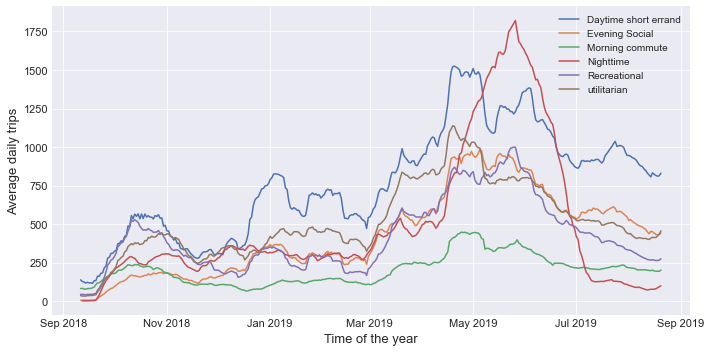

In [90]:
style.use('seaborn-darkgrid')
sns.set_palette("deep")
from matplotlib.dates import DateFormatter
# custom_palette=sns.color_palette("deep", 5)
fig, ax = plt.subplots(figsize=(10, 5))
for i in rolling_avg_df.columns:
    plt.plot(rolling_avg_df[i].rolling(21,center=True).mean(), label=i)

date_form = DateFormatter("%b %Y")
ax.xaxis.set_major_formatter(date_form)

#axis label
plt.xlabel('Time of the year', fontsize=13)
plt.ylabel('Average daily trips', fontsize=13)

_ = ax.tick_params(axis='both', which='major', labelsize=11)
_ = ax.tick_params(axis='both', which='minor', labelsize=11)
plt.legend(fontsize=11)
plt.tight_layout()
plt.savefig('results/TemporalDistribution_RegroupedCluster_TimeOfYear_TimeZoneCorrected_V1.png', dpi=300)
plt.legend()

### Day of the week

In [110]:
time_ofday_data = kmean_results[[
    'trip_id', 'reclassified_cluster', 'trip_start_week_no',
    'trip_start_hour_no'
]].groupby(
    ['trip_start_week_no', 'trip_start_hour_no',
     'reclassified_cluster']).count().rename(columns={'trip_id': 'count'})
time_ofday_df = time_ofday_data.reset_index().pivot(
    index=['trip_start_week_no', 'trip_start_hour_no'],
    columns='reclassified_cluster',
    values='count').fillna(0)

#create empty index
index_array = [np.arange(0, 4, 1), np.arange(0, 24, 1)]
cluster_time_summary = pd.DataFrame(index=pd.MultiIndex.from_product(
    index_array, names=('trip_start_week_no', 'trip_start_hour_no')))

# merge
time_ofday_plot_df=pd.merge(cluster_time_summary,
                                    time_ofday_df,
                                    on=['trip_start_week_no', 'trip_start_hour_no'],
                                    how='left').fillna(0)
time_ofday_plot_df

Daytime short errand  Evening Social  \
trip_start_week_no trip_start_hour_no                                         
0                  0                                    0.0             0.0   
                   1                                    0.0             0.0   
                   2                                    0.0             0.0   
                   3                                    0.0             0.0   
                   4                                    0.0             0.0   
...                                                     ...             ...   
3                  19                                   0.0          5380.0   
                   20                                   0.0          3780.0   
                   21                                   0.0             0.0   
                   22                                   0.0             0.0   
                   23                                   0.0             0.0   

                                       Morning commute  Nighttime  \
trip_start_week_no trip_start_hour_no                               
0                  0                               0.0        0.0   
                   1                               0.0     1235.0   
                   2                               0.0      695.0   
                   3                               0.0      449.0   
                   4                               0.0      314.0   
...                                                ...        ...   
3                  19                              0.0        0.0   
                   20                              0.0        0.0   
                   21                              0.0     6352.0   
                   22                              0.0     5820.0   
                   23                              0.0     5148.0   

                                       Recreational  utilitarian  
trip_start_week_no trip_start_hour_no                             
0                  0                            0.0          0.0  
                   1                            0.0          3.0  
                   2                            0.0          2.0  
                   3                            0.0          2.0  
                   4                            0.0          0.0  
...                                             ...          ...  
3                  19                        2217.0       3880.0  
                   20                        1777.0       2755.0  
                   21                           0.0         12.0  
                   22                           0.0         22.0  
                   23                           0.0         20.0  

[96 rows x 6 columns]

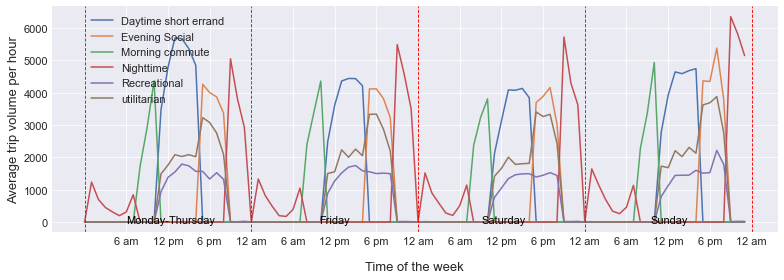

In [112]:
#creating column for weekday no
# data['week_no'] = data.apply(lambda x: x['startDateTime'].weekday(), axis=1)
# data['hour_no'] = data.apply(lambda x: x['startDateTime'].hour, axis=1)
style.use('seaborn-darkgrid')
sns.set_palette("deep")

fig, ax = plt.subplots(figsize=(11, 4))

# for i in np.arange(0, total_clusters, 1):
#     plot_data = kmean_results[kmean_results[selected_cluster] == i]

#     plot_data.groupby(['trip_start_week_no', 'trip_start_hour_no'
#                        ]).size().plot(ax=ax)

time_ofday_plot_df.plot(ax=ax)

for x in np.arange(0, 24 * 5, 24):
    ax.axvline(x=x, color='red', linewidth=0.9, linestyle='--')

day_label = ['Monday-Thursday', 'Friday', 'Saturday', 'Sunday']
day_label_position=[6,33.8,57.1,81.5]

for x in np.arange(1, 5, 1):
    ax.text(day_label_position[x - 1],#-20 + 0.5 * len(day_label[x - 1]) + 24 * x,
            -50,
            day_label[x - 1],
            color='black',
            fontsize=11)

# axis tick label
# ax.set_yticklabels['12,24']

# ax.xaxis.set_minor_locator(MultipleLocator(6))
# ax.xaxis.set_major_locator(MultipleLocator(12))
# ax.set_xticklabels([0, 0, 12, 24, 12, 24, 12, 24, 12, 24, 24, 24, 24])

plt.xticks(np.arange(0,24*4+6,6),['']+['6 am','12 pm','6 pm','12 am']*4)

#axis label
plt.xlabel('Time of the week', fontsize=13, labelpad=15)
plt.ylabel('Average trip volume per hour', fontsize=13)

_ = ax.tick_params(axis='both', which='major', labelsize=11)
_ = ax.tick_params(axis='both', which='minor', labelsize=11)
plt.legend(fontsize=11,loc='upper left', bbox_to_anchor=(0.04, 1))
plt.tight_layout()
plt.savefig('results/TemporalDistribution_RegroupedCluster_TimeOfWeek_TimeZoneCorrected_V1.png', dpi=300)

